### Score Based DiffM (Discrete-time) denoising

Consider a 1D noisy signal  
$$
y \in \mathbb{R}^n,\quad \mu = 0,\quad \mathrm{Cov}(y)=\Sigma.
$$  
We infer noise parameters  
$$
\mu = 0,\quad \Sigma
$$  
using Gibbs Sampling (+ HMC).

**Natural Images**  
$$
\Sigma_\sigma = \Sigma(\sigma,\psi)
$$  
where, sigma^2 = noise amplitude and psi = spectral indeex

**CMB**  
Model temperature fluctuations as  
$$
\mu = 0,\quad \mathrm{Cov}(y) = \Sigma_\phi,
$$  

where  
$$
\Sigma_\phi = \Sigma(H_0,\;\Omega_b,\;\sigma).
$$  

In both cases, we consider a covariance matrix that is diagonal in Fourier space. We write  
$$
\Sigma_\phi = \sigma^2 \cdot \mathbf{F}^\top \mathbf{D}_\psi \mathbf{F},
$$  
where F is the orthonormal discrete DFT matrix, sigma > 0 controls the noise amplitude, and D_psi is a diagonal matrix parameterized by the power spectrum function S_psi(k):  
$$
\mathbf{D}_\psi = \mathrm{diag}(S_\psi(k)).
$$  
$$
\text{Let } \varepsilon \text{ denote the predicted noise and } \hat{\varepsilon}_k = (\mathbf{F} \varepsilon)_k \text{ be its Fourier coefficients.}
$$
The log-posterior  (for HMC sampling) is given by
$$
\log p(\phi \mid \varepsilon = y - x) = \log p(\varepsilon \mid \phi) + \log p(\phi) + C
$$
Then the analytically tractable negative log-likelihood is given by:  
$$
- \log p(\varepsilon \mid \phi) = \frac{1}{2} \sum_k \left[ \log\left(\sigma^2 S_\psi(k)\right) + \frac{|\hat{\varepsilon}_k|^2}{\sigma^2 S_\psi(k)} \right] + C,
$$  
where \( C \) is an arbitrary constant.


#### The WorkFlow

1D execution -> 1D Gibbs-Sampling -> 2D Execution (alter 1D acc.) -> 2D Gibbs Sampling (alter 1D acc.) -> CMB inferencing

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd
import random
import torch
from torch.utils.data import DataLoader, TensorDataset
import math
import warnings
import importlib
warnings.filterwarnings('ignore')

In [2]:
import importlib
import modules
import modules.comp.nn_based
importlib.reload(modules.comp.nn_based)
from modules.comp.nn_based import *
from sklearn.model_selection import train_test_split

In [4]:
batch_size = 32
num_epochs = 20
train_split = 0.8

#### Data-Creation 1D (Synthetic)

In [5]:
import modules.utils.noise_create
importlib.reload(modules.utils.noise_create)
from modules.utils.noise_create import *

import modules.utils.metrics
importlib.reload(modules.utils.metrics)
from modules.utils.metrics import *

In [6]:
def plot_results(noisy, clean, denoised, title=""):
    """
    Plot a few examples comparing the noisy input, clean signal, and denoised output.
    """
    num_examples = 3
    plt.figure(figsize=(8, 4))
    for i in range(num_examples):
        plt.subplot(num_examples, 1, i+1)
        plt.plot(clean[i].squeeze().cpu().numpy(), label="Clean Signal", linewidth=2)
        plt.plot(noisy[i].squeeze().cpu().numpy(), label="Noisy Signal", alpha=0.5)
        plt.plot(denoised[i].squeeze().cpu().detach().numpy(), label="Denoised Output", linestyle="--")
        plt.legend(loc="upper right")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

In [7]:
n_samples = 10000 ## num of samples
n_depth = 100 ## sequence-length
rn = random.randint(0, n_samples)

1D non-flat PSD - GNoise parameterised by (phi, sigma)

In [8]:
true_phi, true_sigma = 1.0, 0.2

(10000, 100) (10000, 100) (10000, 100)


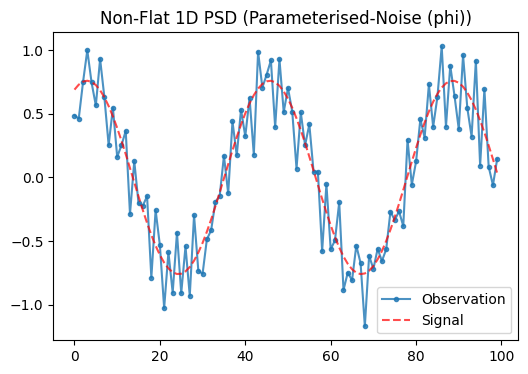

PSNR (clean/noisy):  13.455984024041523
L1 (clean/noisy):  0.17774832


In [9]:
# observation, signal, noise = create_1d_data_colored(n_samples=n_samples, n_depth=n_depth, phi=-1.0, decay=1.0, sigma=0.2)
observation, signal, noise = create_1d_data_colored_multi(n_samples=n_samples, n_depth=n_depth, phi=true_phi, decay=1.0, sigma=true_sigma)
print(observation.shape, signal.shape, noise.shape)

plt.figure(figsize=(6, 4))

plt.plot(observation[rn], label="Observation", alpha=0.8, marker='.')
plt.plot(signal[rn], label="Signal", linestyle="dashed", alpha=0.7, color = 'red')
plt.title('Non-Flat 1D PSD (Parameterised-Noise (phi))')
plt.legend()
plt.show()


print('PSNR (clean/noisy): ', psnr_1d(signal[rn].reshape(1, 1, -1), observation[rn].reshape(1, 1, -1)))
print('L1 (clean/noisy): ', l1_loss_1d(signal[rn].reshape(1, 1, -1), observation[rn].reshape(1, 1, -1)))

In [10]:
observation_train, observation_val, signal_train, signal_val = train_test_split(observation, signal, test_size = 1 - train_split, random_state=28)

print('Shape: ', observation_train.shape, signal_train.shape, observation_val.shape, signal_val.shape)

observation_train = torch.tensor(observation_train, dtype=torch.float32)
signal_train = torch.tensor(signal_train, dtype=torch.float32)
observation_val = torch.tensor(observation_val, dtype=torch.float32)
signal_val = torch.tensor(signal_val, dtype=torch.float32)

dataset_train = TensorDataset(observation_train, signal_train)
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

dataset_val = TensorDataset(observation_val, signal_val)
val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

print(train_loader, val_loader)

Shape:  (8000, 100) (8000, 100) (2000, 100) (2000, 100)
<torch.utils.data.dataloader.DataLoader object at 0x000001542D141D30> <torch.utils.data.dataloader.DataLoader object at 0x000001542D1421E0>


1D Non-Flat PSD - Colored Noise - Sine Signal

In [10]:
# from modules.comp import unet
# from modules.comp import diffusion_1d
# from modules.comp import diff_trainer
# import modules.utils.noise_create
# import modules.utils.hmc

# importlib.reload(modules.comp.unet)
# importlib.reload(modules.comp.diffusion_1d)
# importlib.reload(modules.comp.diff_trainer)
# importlib.reload(modules.utils.noise_create)
# importlib.reload(modules.utils.hmc)

# from modules.comp import unet
# from modules.comp import diffusion_1d
# from modules.comp import diff_trainer

In [84]:
import modules.comp.one_d.unet_1d
importlib.reload(modules.comp.one_d.unet_1d)
from modules.comp.one_d.unet_1d import Unet1DGDiff

import modules.comp.one_d.diffusion_1d
importlib.reload(modules.comp.one_d.diffusion_1d)
from modules.comp.one_d.diffusion_1d import GibbsDiff1D

import modules.comp.diff_trainer
importlib.reload(modules.comp.diff_trainer)
from modules.comp.diff_trainer import TrainerGDiff

from modules.utils.noise_create import create_1d_data, create_1d_data_colored

import modules.utils.hmc
importlib.reload(modules.utils.hmc)
import modules.utils.hmc

In [85]:
gmodel = Unet1DGDiff(
    dim = 16, ## ? Something is wrong here?
    channels=1, 
)

## time-embedding shape -> t = torch.randint(0, self.num_timesteps, (b,), device=device).long() --> (b, )
t_shape = (2, )
x_shape = (2, 1, 100)

print(x_shape, t_shape)

print('- UNET-summary -')
gmodel.summary(x_shape=x_shape, t_shape=t_shape)

### Just the diffusion framework
gdiffusion = GibbsDiff1D(
    gmodel,
    seq_len = 100,
    num_timesteps = 1000,
)

Dimension-Cluster:  16 32 64 128 256
(2, 1, 100) (2,)
- UNET-summary -
Careful, no alpha was given, set to 0
____________________________________________________________________________________________________
Model: Unet1D
Layer (type)                            Output Shape             Param #        
input_1 (InputLayer)                    (2, 1, 100)              0              
input_2 (InputLayer)                    (2,)                     0              
init_conv.proj (Conv1d)                 (2, 16, 100)             64             
init_conv.norm (LayerNorm)              (2, 100, 16)             32             
init_conv.act (SiLU)                    (2, 16, 100)             0              
down_blocks.0.block1.proj (Conv1d)      (2, 32, 100)             1568           
down_blocks.0.block1.norm (LayerNorm)   (2, 100, 32)             64             
down_blocks.0.block1.act (SiLU)         (2, 32, 100)             0              
down_blocks.0.block1 (BlockGDiff)       (2, 32,

In [86]:
print(signal_train.shape, signal_val[:50].shape)

torch.Size([8000, 100]) torch.Size([50, 100])


In [87]:
train_num_steps = 1000

In [88]:
gtrainer = TrainerGDiff(
    gdiffusion,
    signal_train,
    signal_val[:50],
    train_batch_size = 8,
    train_lr = 1e-5,
    train_num_steps = train_num_steps, # total training steps
    gradient_accumulate_every = 2,     # gradient accumulation steps
    ema_decay = 0.995,                 # exponential moving average decay
)

train_loss_curve, val_loss_curve = gtrainer.train()

Optimization Steps: 100%|██████████| 1000/1000 [07:55<00:00,  2.10it/s]

Training complete.


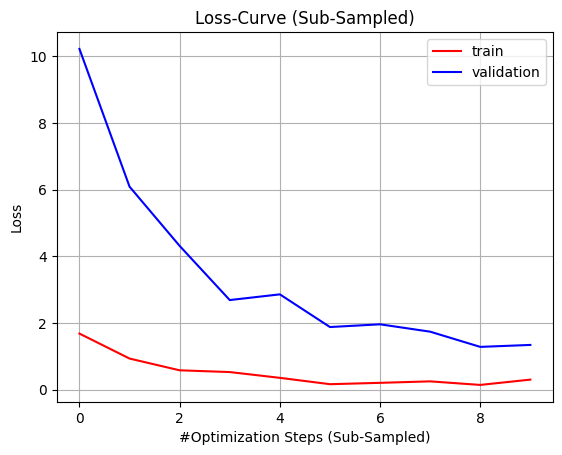

In [89]:
fig = plt.Figure(figsize=(7, 7))

rate = 100
plt.plot(np.arange(train_num_steps // rate), train_loss_curve[::rate], color = 'red', label = 'train')
plt.plot(np.arange(train_num_steps // rate), val_loss_curve[::rate], color = 'blue', label = 'validation')

plt.ylabel('Loss')
plt.xlabel('#Optimization Steps (Sub-Sampled)')
plt.title('Loss-Curve (Sub-Sampled)')

plt.grid()
plt.legend()
plt.show()

##### Load Model

In [ ]:
checkpoint = torch.load('gdiffusion_model.pth', map_location='cpu')

In [ ]:
# Rebuild the UNet with same architecture
gmodel = Unet1DGDiff(
    dim = checkpoint['config']['params']['input_dim'],
    channels = 1,
)

# Rebuild the diffusion wrapper
gdiffusion = GibbsDiff1D(
    gmodel,
    seq_len = checkpoint['config']['seq_len'],
    num_timesteps = checkpoint['config']['num_timesteps'],
)

# Load weights
gdiffusion.model.load_state_dict(checkpoint['model_state_dict'])
gdiffusion.model.eval()

Non-Blind denoising

In [90]:
yt, x0 = observation_val[0].view(1, 1, -1), signal_val[0].view(1, 1, -1)
print(x0.shape, yt.shape)

torch.Size([1, 1, 100]) torch.Size([1, 1, 100])


In [91]:
phi = true_phi
sigma = true_sigma

In [92]:
sigma_timestep = gdiffusion.get_closest_timestep(torch.tensor([sigma]).to(device)).item()
print('closest_discrete_timestep: ', sigma_timestep)

sigma_timestep = torch.tensor(sigma_timestep).unsqueeze(0).repeat(yt.shape[0])
print(sigma_timestep)

x_denoised = gdiffusion.denoise_samples_batch_time(yt, sigma_timestep, phi_ps=phi).cpu().numpy()
print(x_denoised.shape)

closest_discrete_timestep:  57
tensor([57])
(1, 1, 100)


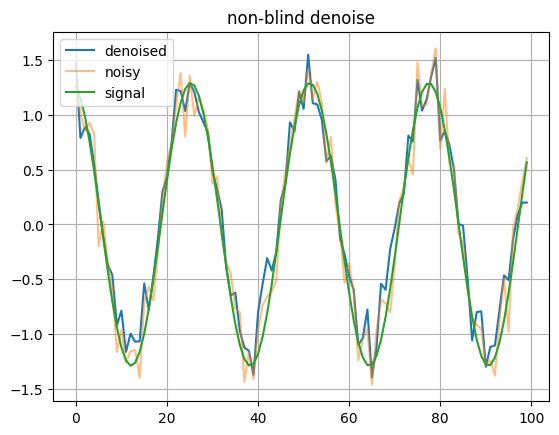

PSNR (clean/denoised):  13.549165023637219
L1 (clean/denoised):  0.16592802

PSNR (clean/noisy):  13.913019426771429
L1 (clean/noisy):  0.17004137


In [93]:
plt.plot(x_denoised[0][0], label = 'denoised')
plt.plot(yt[0][0], label = 'noisy', alpha = 0.5)
plt.plot(x0[0][0], label = 'signal')

plt.title('non-blind denoise')

plt.grid()
plt.legend()
plt.show()

print('PSNR (clean/denoised): ', psnr_1d(x0.cpu().numpy(), x_denoised))
print('L1 (clean/denoised): ', l1_loss_1d(x0.cpu().numpy(), x_denoised))

print()

print('PSNR (clean/noisy): ', psnr_1d(x0.cpu().numpy(), yt.cpu().numpy()))
print('L1 (clean/noisy): ', l1_loss_1d(x0.cpu().numpy(), yt.cpu().numpy()))

Noising -> Denosing (non-blind) (the multi-batching not working for either of denoising)

In [94]:
sigmas = [0.2] ## noise-amplitude
phis = [-1, 0, 1]

sigmas = [gdiffusion.get_closest_timestep(torch.tensor([s]).to(device), ret_sigma=True)[1].item() for s in sigmas]

torch.Size([1, 1, 100])
Sigma:  0.1986703872680664
Phi:  -1
(1, 1, 100)


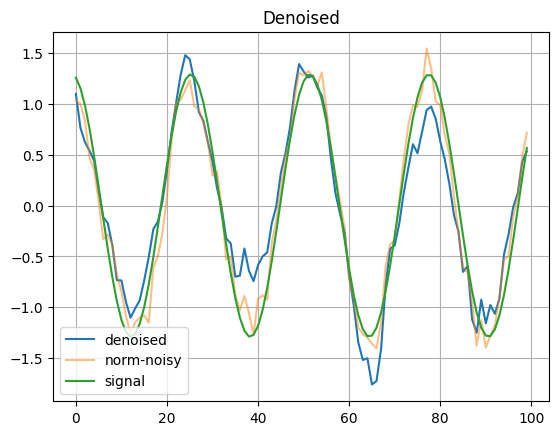

PSNR (clean/denoised):  10.972220412402883
L1 (clean/denoised):  0.23364063
Sigma:  0.1986703872680664
Phi:  0
(1, 1, 100)


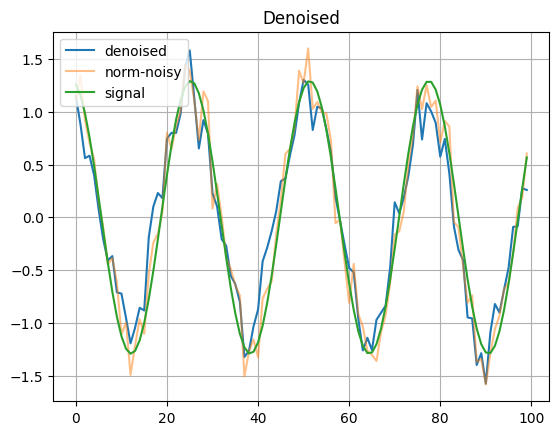

PSNR (clean/denoised):  11.84134689923802
L1 (clean/denoised):  0.2055398
Sigma:  0.1986703872680664
Phi:  1
(1, 1, 100)


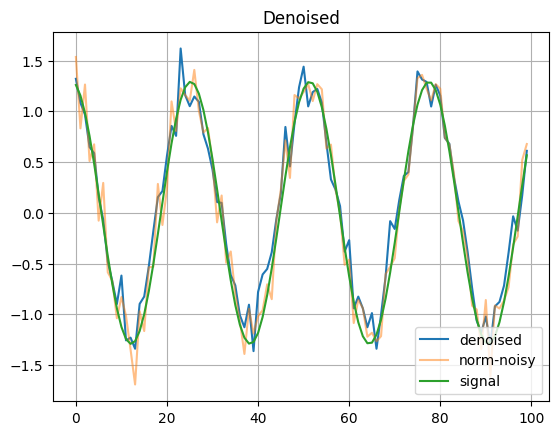

PSNR (clean/denoised):  13.999122646272966
L1 (clean/denoised):  0.15902062


In [96]:
x = signal_val[0].view(1, 1, -1)
print(x.shape)

for sigma_idx, sigma in enumerate(sigmas):
    for phi_idx, phi in enumerate(phis):
        
        print('Sigma: ', sigma)
        print('Phi: ', phi)

        # Make test data and auxilary variables
        sigma_timestep = gdiffusion.get_closest_timestep(torch.tensor([sigma]).to(device)).item()
        alpha_bar_t = gdiffusion.alpha_bar_t[sigma_timestep].reshape(-1, 1, 1).to(device)
        eps, psd =  get_colored_noise_1d(x.shape, phi=phi)
        eps = torch.sqrt(1 - alpha_bar_t)/torch.sqrt(alpha_bar_t) * eps.to(device)
        y = x + eps # Noisy image
        psd = (torch.sqrt(1 - alpha_bar_t)/torch.sqrt(alpha_bar_t))**2 * psd.to(device) * x.shape[-1] * x.shape[-2]
        yt = torch.sqrt(alpha_bar_t) * y # Noisy image normalized for the diffusion model

        ## x_0_hat // Point-Estimate
        x_denoised = gdiffusion.denoise_samples_batch_time(yt, torch.tensor(sigma_timestep).unsqueeze(0).repeat(yt.shape[0]), phi_ps=phi).detach().cpu().numpy()
        print(x_denoised.shape)

        fig = plt.Figure(figsize=(6, 6))

        plt.plot(np.squeeze(x_denoised), label = 'denoised')
        plt.plot(np.squeeze(yt.detach().cpu().numpy()), label = 'norm-noisy', alpha = 0.5)
        plt.plot(np.squeeze(x), label = 'signal')

        plt.grid()
        plt.legend()
        plt.title('Denoised')
        plt.show()

        print('PSNR (clean/denoised): ', psnr_1d(x.cpu().numpy(), x_denoised))
        print('L1 (clean/denoised): ', l1_loss_1d(x.cpu().numpy(), x_denoised))

        ## E[x|y] // Posterior-Distribution
        # repeat = 20
        # yt_rep = yt.repeat(repeat, 1, 1)
        # t_rep = torch.tensor(sigma_timestep).unsqueeze(0).repeat(yt.shape[0]*repeat)
        # print(yt_rep.shape, t_rep.shape)
        
        # x_denoised_mean = gdiffusion.denoise_samples_batch_time(yt_rep, t_rep, phi_ps=phi)
        # x_denoised_mean = x_denoised_mean.reshape(repeat, yt.shape[0], 1, yt.shape[2], yt.shape[3]).mean(dim=0)
        # print(x_denoised_mean.shape)

Blind-Denoising (only inferencing SO need improvisation) (VERY IMPORTANT)

It needs y and yt(normalized based on alpha_bar_t) both for blind-denosing | So I'll need to have <code>sigma</code> all the time? 
HMC sampling here is more simpler here with fixed mass-matrix and KE energy term is also simpler 

In [97]:
init_sigma = 0.4 ## initialized-sigma

In [98]:
y, x0 = observation_val[0].view(1, 1, -1), signal_val[0].view(1, 1, -1)
print(x0.shape, y.shape)

sigma_timestep = gdiffusion.get_closest_timestep(torch.tensor([init_sigma]).to(device)).item()
print('closest_discrete_timestep: ', sigma_timestep)

alpha_bar_t = gdiffusion.alpha_bar_t[sigma_timestep].reshape(-1, 1, 1).to(device)
yt = torch.sqrt(alpha_bar_t) * y 

print(y.shape, yt.shape)

torch.Size([1, 1, 100]) torch.Size([1, 1, 100])
closest_discrete_timestep:  117
torch.Size([1, 1, 100]) torch.Size([1, 1, 100])


Point-Estimate

In [99]:
print('x_0_hat (Point-Estimate):')
## x_0_hat, phi_hat -- point estimate - single chain run
phi_sampled, x_denoised = gdiffusion.run_gibbs_sampler(y, yt, num_chains_per_sample=1, n_it_gibbs=5, n_it_burnin=2)
print(phi_sampled.shape, x_denoised.shape)
print('phi_sampled: ', phi_sampled)

x_0_hat (Point-Estimate):
torch.Size([1, 2]) torch.Size([1, 1, 100])
phi_sampled:  tensor([[0.3838, 0.3485]])


Posterior-Distribution

In [100]:
## x_0_hat, phi_hat -- point estimate - single chain run

print('x_0_hat (Posterior-Distribution):')

## n_it_gibbs = chain_length | shape ~ (#chains (post_samples = different chain realisation), batch_size, last_few_states (avg_pmean), *rem-dim)
phi_all_posterior, x_denoised_posterior = gdiffusion.blind_posterior_mean(y, yt, num_chains_per_sample=100, n_it_gibbs=50, n_it_burnin=15, avg_pmean=2, return_post=True)

phi_all_posterior = phi_all_posterior.mean(dim=2)
x_denoised_posterior = x_denoised_posterior.mean(dim=2)

print('phi_all_posterior: ', phi_all_posterior.shape)
print('x_denoised_posterior: ', x_denoised_posterior.shape)

x_0_hat (Posterior-Distribution):
phi_all_posterior:  torch.Size([100, 1, 2])
x_denoised_posterior:  torch.Size([100, 1, 1, 100])


##### select a pair

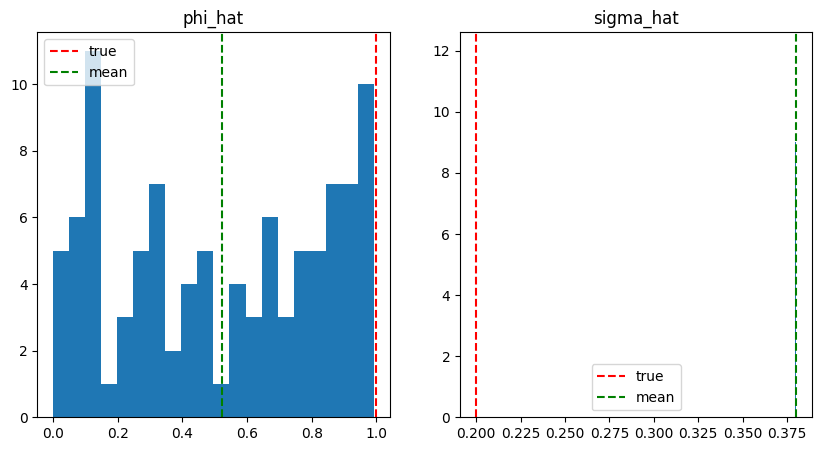

In [109]:
idx = 0

phi_hat = phi_all_posterior[:, idx, 0]
sigma_hat = phi_all_posterior[:, idx, 1]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].hist(phi_hat, bins = 20)
axs[0].set_title('phi_hat')
axs[0].axvline(true_phi, color='red', linestyle='--', label='true')
axs[0].axvline(phi_hat.mean(dim=0), color='green', linestyle='--', label='mean')
axs[0].legend()

axs[1].hist(sigma_hat, bins = 20)
axs[1].set_title('sigma_hat')
axs[1].axvline(true_sigma, color='red', linestyle='--', label='true')
axs[1].axvline(sigma_hat.mean(dim=0), color='green', linestyle='--', label='mean')
axs[1].legend()

plt.show()

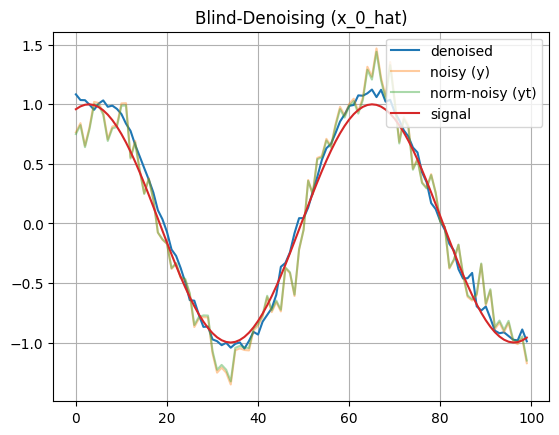

In [ ]:
# x_denoised = x_denoised.numpy()

plt.plot(x_denoised[0][0], label = 'denoised')
plt.plot(y[0][0], label = 'noisy (y)', alpha = 0.4)
plt.plot(yt[0][0], label = 'norm-noisy (yt)', alpha = 0.4)
plt.plot(x0[0][0], label = 'signal')

plt.legend()
plt.grid()
plt.title('Blind-Denoising (x_0_hat)')
plt.show()

print('PSNR (clean/noisy): ', psnr_1d(x0.cpu().numpy(), x_denoised).item())
print('L1 (clean/noisy): ', l1_loss_1d(x0.cpu().numpy(), x_denoised).item())

LATER (expectation over posterior joint distribution )

In [ ]:
print('E[X|Y]:')
## E[x|y] - expectation over posterior joint distribution 
phi_sampled_mean, x_denoised_mean = gdiffusion.blind_posterior_mean(y, yt) 
print(phi_sampled_mean.shape, x_denoised_mean.shape)

#### Questions -
1. we need to index the t to noisy image for normalizing it - how is that denoising blind then (we need y and yt (for posterior sampling))
2. Do we need to replicate the entire pipeline (architechture and data-training) (OR a subset would suffice)

### 2D Image Data (ImageNet)

Need to train on ~ 1.2M image samples (the Kaggle Imagenet subset)

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd
import random
import torch
from torch.utils.data import DataLoader, TensorDataset
import math
import warnings
import importlib
warnings.filterwarnings('ignore')
import time

from sklearn.model_selection import train_test_split

In [78]:
import importlib
import modules
import modules.comp.nn_based
importlib.reload(modules.comp.nn_based)
from modules.comp.nn_based import *
from sklearn.model_selection import train_test_split

In [79]:
## ImageNet subset ~1k
import cv2 as cv
import torchvision
import torchvision.datasets

import os 
import zipfile

In [80]:
batch_size = 32
num_epochs = 20
train_split = 0.8

In [5]:
zip_path = "data/archive.zip"
extract_dir = 'data/tiny-imagenet/'  # Use '.' to extract to current directory

In [6]:
if not os.path.exists(extract_dir):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print("data archive succesfully extracted")
else:
    print('data archive already extracted')

data archive already extracted


For Testing I'm using Tiny-ImageNet - (For actual Dataset I can't load all the data at once - need to use pytorch/python generators)

In [7]:
def tiny_imagenet_file_handler(source_path, return_path = True):
    train_path = os.path.join(source_path, 'tiny-imagenet-200/train')
    test_path = os.path.join(source_path, 'tiny-imagenet-200/test/images')

    train_class_path = [os.path.join(train_path, class_id + '/images') for class_id in os.listdir(train_path)]
    
    train_image_path = []
    for tp in train_class_path:
        for image_id in os.listdir(tp):
            train_image_path.append(os.path.join(tp, image_id))

    test_image_path = []
    for image_id in os.listdir(test_path):
        test_image_path.append(os.path.join(test_path, image_id))

    print('#train_images: ', len(train_image_path))
    print('#test_images: ', len(test_image_path))

    if return_path:
        return train_image_path, test_image_path


In [8]:
train_image_path, test_image_path = tiny_imagenet_file_handler(extract_dir)

#train_images:  68920
#test_images:  10000


(64, 64, 3)


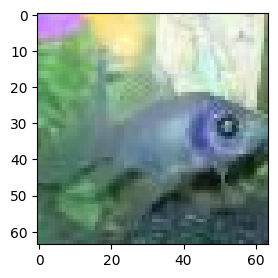

In [9]:
img = cv.imread(train_image_path[0])
print(img.shape)

fig = plt.figure(figsize = (3, 3))
plt.imshow(img)
plt.show()

In [262]:
import modules.utils.noise_create_2d
importlib.reload(modules.utils.noise_create_2d)
from modules.utils.noise_create_2d import *

In [265]:
subset_sample_len = 5000
phi = 1.0
sigma = 0.2
decay = 1.0 ## no-decay
input_size = (12, 12)

In [266]:
ft = time.time()
observation_2d, images_2d, noise_2d = create_2d_data_colored(train_image_path, n_samples = subset_sample_len, phi=phi, sigma=sigma, is_plot=False, size=input_size)
print("observation, images, noise: ", observation_2d.shape, images_2d.shape, noise_2d.shape)
lt = time.time()

print('time-taken for dataset-creation: ', (lt - ft)/60, ' mins')

observation, images, noise:  torch.Size([5000, 3, 12, 12]) torch.Size([5000, 3, 12, 12]) torch.Size([5000, 3, 12, 12])
time-taken for dataset-creation:  0.15349942843119305  mins


In [268]:
rand_idx = torch.randperm(subset_sample_len)

train_observation_2d, val_observation_2d = observation_2d[rand_idx][:int(train_split * subset_sample_len)], observation_2d[rand_idx][int(train_split * subset_sample_len):] 
train_images_2d, val_images_2d = images_2d[rand_idx][:int(train_split * subset_sample_len)], images_2d[rand_idx][int(train_split * subset_sample_len):] 
train_noise_2d, val_noise_2d = noise_2d[rand_idx][:int(train_split * subset_sample_len)], noise_2d[rand_idx][int(train_split * subset_sample_len):] 

# train_observation_2d, val_observation_2d, train_images_2d, train_images_2d, train_noise_2d, val_noise_2d = train_test_split(observation_2d, images_2d, noise_2d, train_size=train_split)
print(train_observation_2d.shape, val_observation_2d.shape, train_images_2d.shape, val_images_2d.shape, train_noise_2d.shape, val_noise_2d.shape)

torch.Size([4000, 3, 12, 12]) torch.Size([1000, 3, 12, 12]) torch.Size([4000, 3, 12, 12]) torch.Size([1000, 3, 12, 12]) torch.Size([4000, 3, 12, 12]) torch.Size([1000, 3, 12, 12])


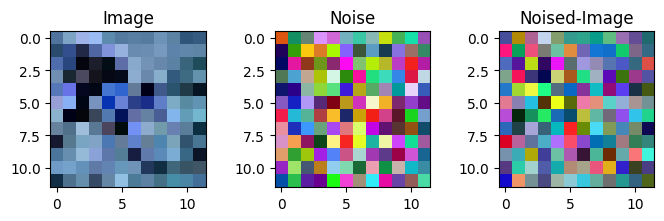

In [269]:
fig, axs = plt.subplots(1, 3, figsize = (7, 7))

_, c, w, h = train_observation_2d.shape
rn = random.randint(0, int(train_split * subset_sample_len) - 1)

sample_obv, sample_img, sample_noise = train_observation_2d[rn].view(w, h, -1).numpy(), train_images_2d[rn].view(w, h, -1).numpy(), train_noise_2d[rn].view(w, h, -1).numpy()
sample_obv, sample_img, sample_noise = (sample_obv * 255.0).astype('uint8'), (sample_img * 255.0).astype('uint8'), (sample_noise * 255.0).astype('uint8')

axs[2].imshow(sample_obv)
axs[2].set_title('Noised-Image')

axs[0].imshow(sample_img)
axs[0].set_title('Image')

axs[1].imshow(sample_noise)
axs[1].set_title('Noise')

plt.tight_layout(pad=2)
plt.show()

In [270]:
import modules.comp.two_d.unet_2d
importlib.reload(modules.comp.two_d.unet_2d)
from modules.comp.two_d.unet_2d import Unet2DGDiff

In [271]:
import modules.comp.two_d.diffusion_2d
importlib.reload(modules.comp.two_d.diffusion_2d)
from modules.comp.two_d.diffusion_2d import GibbsDiff2D

In [272]:
gmodel_2d = Unet2DGDiff(
    dim = 12, ## ? Something is wrong here?
    channels=3, 
)

## time-embedding shape -> t = torch.randint(0, self.num_timesteps, (b,), device=device).long() --> (b, )
t_shape = (2, )
x_shape = (2, 3, *input_size)

print(x_shape, t_shape)

print('- UNET-summary -')
gmodel_2d.summary(x_shape=x_shape, t_shape=t_shape)

(2, 3, 12, 12) (2,)
- UNET-summary -
____________________________________________________________________________________________________
Model: Unet1D
Layer (type)                            Output Shape             Param #        
input_1 (InputLayer)                    (2, 3, 12, 12)           0              
input_2 (InputLayer)                    (2,)                     0              
init_conv.proj (Conv2d)                 (2, 12, 12, 12)          336            
init_conv.norm (GroupNorm)              (2, 12, 12, 12)          24             
init_conv.act (SiLU)                    (2, 12, 12, 12)          0              
init_conv.dropout (Dropout2d)           (2, 12, 12, 12)          0              
down_blocks.0.block1.proj (Conv2d)      (2, 24, 12, 12)          2616           
down_blocks.0.block1.norm (GroupNorm)   (2, 24, 12, 12)          48             
down_blocks.0.block1.act (SiLU)         (2, 24, 12, 12)          0              
down_blocks.0.block1.dropout (Dropout2

In [273]:
### Just the diffusion framework
gdiffusion_2d = GibbsDiff2D(
    gmodel_2d,
    image_size = (3, *input_size),
    num_timesteps = 1000,
)

In [274]:
import modules.comp.diff_trainer
importlib.reload(modules.comp.diff_trainer)
from modules.comp.diff_trainer import TrainerGDiff

In [275]:
print(train_images_2d.shape)

torch.Size([4000, 3, 12, 12])


In [277]:
train_num_steps = 30000

In [278]:
gtrainer = TrainerGDiff(
    gdiffusion_2d,
    train_images_2d,
    val_images_2d[:50],
    train_batch_size = 8,
    train_lr = 1e-5,
    train_num_steps = train_num_steps, # total training steps
    gradient_accumulate_every = 2,     # gradient accumulation steps
    ema_decay = 0.995,                 # exponential moving average decay
    mode = '2D'
)

ft = time.time()
train_loss_curve, val_loss_curve = gtrainer.train()
lt = time.time()

print('time-taken: ', (lt - ft)/60)

Optimization Steps: 100%|██████████| 30000/30000 [3:58:13<00:00,  2.10it/s]   

Training complete.


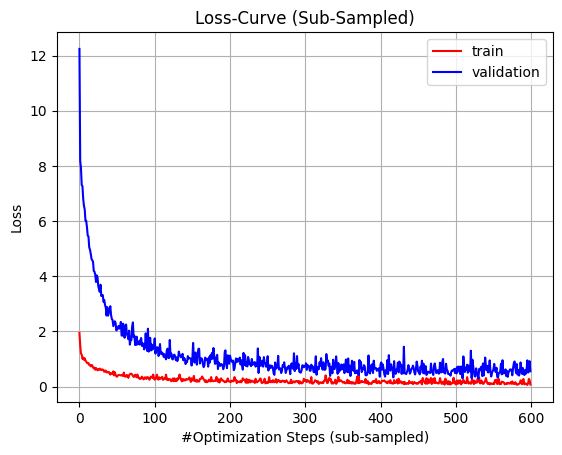

In [281]:
fig = plt.Figure(figsize=(7, 7))

rate = 50
plt.plot(np.arange(train_num_steps // rate), train_loss_curve[::rate], color = 'red', label = 'train')
plt.plot(np.arange(train_num_steps // rate), val_loss_curve[::rate], color = 'blue', label = 'validation')

plt.ylabel('Loss')
plt.xlabel('#Optimization Steps (sub-sampled)')
plt.title('Loss-Curve (Sub-Sampled)')

plt.grid()
plt.legend()
plt.show()

#### Load-Model

In [ ]:
checkpoint = torch.load('gdiffusion_2d_model.pth', map_location='cpu')

In [ ]:
# Rebuild the UNet with same architecture
gmodel = Unet1DGDiff(
    dim = checkpoint['config']['params']['input_dim'],
    channels = 1,
)

# Rebuild the diffusion wrapper
gdiffusion = GibbsDiff1D(
    gmodel,
    seq_len = checkpoint['config']['seq_len'],
    num_timesteps = checkpoint['config']['num_timesteps'],
)

# Load weights
gdiffusion.model.load_state_dict(checkpoint['model_state_dict'])
gdiffusion.model.eval()

Non-Blind Denoising (2D)

In [282]:
import modules.utils.metrics
importlib.reload(modules.utils.metrics)
from modules.utils.metrics import *

In [283]:
phi = 1.0
sigma = 0.2

In [284]:
yt, x0 = val_observation_2d[0].view(1, 3, *input_size), val_images_2d[0].view(1, 3, *input_size)
print(x0.shape, yt.shape)

torch.Size([1, 3, 12, 12]) torch.Size([1, 3, 12, 12])


In [285]:
sigma_timestep = gdiffusion_2d.get_closest_timestep(torch.tensor([sigma]).to(device)).item()
print('closest_discrete_timestep: ', sigma_timestep)

sigma_timestep = torch.tensor(sigma_timestep).unsqueeze(0).repeat(yt.shape[0])
print(sigma_timestep)

x_denoised = gdiffusion_2d.denoise_samples_batch_time(yt, sigma_timestep, phi_ps=phi).cpu().numpy()
print(x_denoised.shape)

closest_discrete_timestep:  57
tensor([57])
(1, 3, 12, 12)


In [286]:
x0 = x0.cpu().numpy().reshape(1, *input_size, 3).astype('float32')
x_denoised = x_denoised.reshape(1, *input_size, 3).astype('float32')
yt = yt.cpu().numpy().reshape(1, *input_size, 3).astype('float32')

print(x0.shape, x_denoised.shape, yt.shape)

(1, 12, 12, 3) (1, 12, 12, 3) (1, 12, 12, 3)


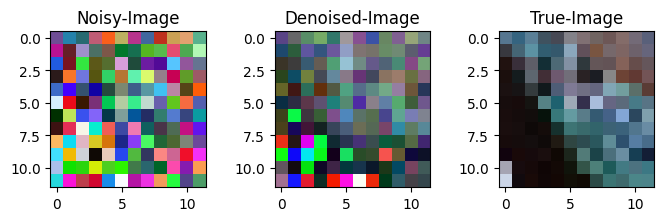

PSNR (clean/denoised):  16.3180341758004
SSIM (clean/denoised):  0.3273836
L1 (clean/denoised):  0.120816834

PSNR (clean/noisy):  13.646645349239261
SSIM (clean/denoised):  0.29623067
L1 (clean/noisy):  0.16593485


In [287]:
fig, axs = plt.subplots(1, 3, figsize=(7, 7))

axs[1].imshow((x_denoised[0] * 255).astype('uint8'))
axs[1].set_title('Denoised-Image')

axs[0].imshow((yt[0] * 255).astype('uint8'))
axs[0].set_title('Noisy-Image')

axs[2].imshow((x0[0] * 255).astype('uint8'))
axs[2].set_title('True-Image')

plt.tight_layout(pad = 2)
plt.show()

print('PSNR (clean/denoised): ', psnr_2d(x0, x_denoised))
print('SSIM (clean/denoised): ', ssim_2d(x0, x_denoised))
print('L1 (clean/denoised): ', l1_loss_2d(x0, x_denoised))

print()

print('PSNR (clean/noisy): ', psnr_2d(x0, yt))
print('SSIM (clean/denoised): ', ssim_2d(x0, yt))
print('L1 (clean/noisy): ', l1_loss_2d(x0, yt))

Blind-Denoising

In [ ]:
## Gaussian-Paramaters used for noise-creation
true_phi = 1.0
true_sigma = 0.2

In [288]:
import modules.utils.hmc
importlib.reload(modules.utils.hmc)
import modules.utils.hmc

In [289]:
y, x0 = val_observation_2d[0].view(1, 3, *input_size), val_images_2d[0].view(1, 3, *input_size)
print(x0.shape, y.shape)

sigma_timestep = gdiffusion_2d.get_closest_timestep(torch.tensor([sigma]).to(device)).item()
print('closest_discrete_timestep: ', sigma_timestep)

### t-indexed normalization
alpha_bar_t = gdiffusion_2d.alpha_bar_t[sigma_timestep].reshape(-1, 1, 1, 1).to(device)
yt = torch.sqrt(alpha_bar_t) * y 

print(y.shape, yt.shape)

torch.Size([1, 3, 12, 12]) torch.Size([1, 3, 12, 12])
closest_discrete_timestep:  57
torch.Size([1, 3, 12, 12]) torch.Size([1, 3, 12, 12])


In [ ]:
print('x_0_hat (Point-Estimate):')
## x_0_hat, phi_hat -- point estimate - single chain run
phi_sampled, x_denoised = gdiffusion_2d.run_gibbs_sampler(y, yt, num_chains_per_sample=1, n_it_gibbs=100, n_it_burnin=20)
print(phi_sampled.shape, x_denoised.shape)
print('phi_hat: ', phi_sampled)

x_0_hat:
torch.Size([1, 2]) torch.Size([1, 3, 12, 12])
phi_hat:  tensor([[0.1445, 0.1752]])


In [ ]:
x_denoised = x_denoised.cpu().numpy().reshape(x_denoised.shape[0], *input_size, 3).astype('float32')
y = y.cpu().numpy().reshape(y.shape[0], *input_size, 3).astype('float32')
yt = yt.cpu().numpy().reshape(yt.shape[0], *input_size, 3).astype('float32')
x0 = x0.cpu().numpy().reshape(x0.shape[0], *input_size, 3).astype('float32')

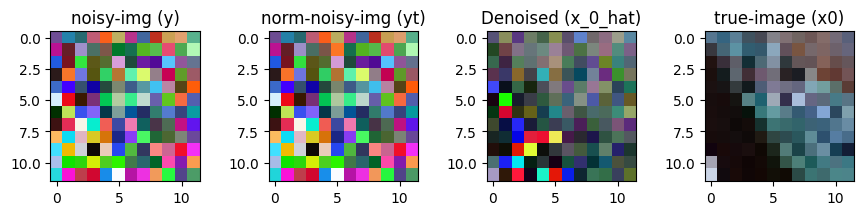

PSNR (clean/denoised):  16.591425554697697
SSIM (clean/denoised):  0.30264476
L1 (clean/denoised):  0.116277374


In [292]:
# x_denoised = x_denoised.numpy()

fig, axs = plt.subplots(1, 4, figsize=(9, 9)) 

axs[2].imshow((x_denoised[0] * 255).astype('uint8'))
axs[2].set_title('Denoised (x_0_hat)')

axs[0].imshow((y[0] * 255).astype('uint8'))
axs[0].set_title('noisy-img (y)')

axs[1].imshow((yt[0] * 255).astype('uint8'))
axs[1].set_title('norm-noisy-img (yt)')

axs[3].imshow((x0[0] * 255).astype('uint8'))
axs[3].set_title('true-image (x0)')

plt.tight_layout(pad=2)
plt.show()

print('PSNR (clean/denoised): ', psnr_2d(x0, x_denoised))
print('SSIM (clean/denoised): ', ssim_2d(x0, x_denoised))
print('L1 (clean/denoised): ', l1_loss_2d(x0, x_denoised))